In [1]:
from collections import defaultdict
import math
import queue
from pprint import pprint
from IPython.core.debugger import set_trace

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import torchvision.datasets as datasets
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torchvision.transforms import Compose

from src.classification.models.alexnet import AlexNet


In [2]:
%matplotlib widget
%load_ext autoreload
%autoreload 2

## Model

### Create Model

In [3]:
alexnet = AlexNet(10)

In [4]:
cuda = torch.device("cuda:2")

In [5]:
alexnet = alexnet.to(cuda)

## Dataset 

### Define Transforms

In [6]:
def to_rgb(img):
    return np.repeat(img[..., None], 3, axis=2)

def to_numpy(img):
    return np.array(img)

def resize(img, size=(224, 224)):
    return cv2.resize(img, size)


def to_torch(img):
    return torch.from_numpy(np.transpose(img, (2, 0, 1)).astype(np.float32))

In [7]:
img_transform = Compose([
    to_numpy,
    to_rgb,
    resize, 
    to_torch,
])
def target_transform(label):
    return torch.Tensor(label)

### Create Dataset

In [8]:
mnist_testset = datasets.MNIST(
    root='./resources/classification/', 
    train=False, 
    download=True, 
    transform=img_transform,
)
mnist_trainset = datasets.MNIST(
    root='./resources/classification/', 
    train=True, 
    download=True, 
    transform=img_transform,
)

### Create Dataloader

In [9]:
train_dl = DataLoader(mnist_trainset, batch_size=32)
test_dl = DataLoader(mnist_testset, batch_size=32)

## Evaluation

In [10]:
class WindowCollector:
    
    def __init__(self, window_size=None):
        self._windows = defaultdict(lambda: queue.deque(maxlen=window_size))
        
    def add_value(self, name, value):
        self._windows[name].append(value)
        
    def get_value(self, name, apply=np.mean):
        return apply(self._windows[name])
    
    def get_summary(self, apply=np.mean):
        return {k: apply(v) for k, v in self._windows.items()}

In [11]:
class StepCollector:
    def __init__(self, steps):
        self._steps = steps
        self._accumulators = defaultdict(int)
        
    def add_value(self, name, value):
        self._accumulators[name] += value / self._steps
        
    def get_value(self, name):
        return self._accumulators[name]
    
    def get_summary(self):
        return {k: v for k, v in self._accumulators.items()}

In [12]:
class ClassificationMetrics:
    
    def __init__(self):
        self._confussion_matrix = defaultdict(lambda: defaultdict(int))
    
    def add(self, gt, pred):
        self._confussion_matrix[gt][pred] += 1
        
    def adds(self, gts, preds):
        for gt, pred in zip(gts, preds):
            self.add(gt, pred)
            
    @property
    def total(self):
        return sum(
            v 
            for vs in self._confussion_matrix.values() 
            for v in vs.values()
        )
    
    @property
    def accuracy(self):
        return sum(
            self._confussion_matrix[label][label] 
            for label in self._confussion_matrix.keys()
        ) / self.total
    
    def get_summary(self):
        return {"accuracy": self.accuracy}
        

## Train

### Define Train Loop

In [13]:
def transpose_history(fit_history):
    epoch_sumarries = defaultdict(lambda: defaultdict(list))
    def _transpose(stage, epoch_sumarry):
        for name, val in epoch_sumary[stage].items():
            epoch_sumarries[name][stage].append(val)
            
    for epoch_summary in fit_history:
        _transpose("train", epoch_summary)
        _transpose("eval", epoch_summary)
    return {k: dict(v) for k, v in epoch_sumarries.items()}

In [14]:
def plot_summary(summary):
    for name, values_mapp in summary.items():
        fig, ax = plt.subplots()
        ax.set_title(name)
        ax.set_xlabel("epoch")
        for stage_name, values in values_mapp.items():
            ax.plot(values, label=stage_name)
        plt.show()
    

In [15]:
def evaluate_one_epoch(model, optimizer, val_dataloader, loss_fn, device):
    collector = WindowCollector(window_size=20)
    epoch_collector = StepCollector(steps=len(val_dataloader))
    metrics = ClassificationMetrics()
    
    model.eval()
    with tqdm(total=len(val_dataloader)) as tbar:
        with torch.no_grad():
            for imgs, target_labels in val_dataloader:
                optimizer.zero_grad(set_to_none=True)
                labels_probs = model(imgs.to(device))
                loss_value = loss_fn(labels_probs, target_labels.to(device))

                metrics.adds(
                    target_labels.numpy(), 
                    torch.argmax(labels_probs, dim=1).cpu().numpy(),
                )
                epoch_collector.add_value("eval_loss", loss_value.item())
                collector.add_value("eval_loss", loss_value.item())
                tbar.set_postfix({**collector.get_summary(), **metrics.get_summary()})
                tbar.update()
    return {**epoch_collector.get_summary(), **metrics.get_summary()}


In [16]:
def train_one_epoch(model, optimizer, train_dataloader, loss_fn, device):
    collector = WindowCollector(window_size=20)
    epoch_collector = StepCollector(steps=len(train_dataloader))
    metrics = ClassificationMetrics()
    
    model.train()
    with tqdm(total=len(train_dataloader)) as tbar:
        for imgs, target_labels in train_dataloader:
            optimizer.zero_grad(set_to_none=True)
            labels_probs = model(imgs.to(device))
            loss_value = loss_fn(labels_probs, target_labels.to(device))
            loss_value.backward()
            optimizer.step()
            
            metrics.adds(
                target_labels.numpy(), 
                torch.argmax(labels_probs, dim=1).cpu().numpy(),
            )
            epoch_collector.add_value("loss", loss_value.item())
            collector.add_value("loss", loss_value.item())
            tbar.set_postfix({**collector.get_summary(), **metrics.get_summary()})
            tbar.update()
    return {**epoch_collector.get_summary(), **metrics.get_summary()}
    

In [17]:
optimizer = torch.optim.SGD(alexnet.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [18]:
def fit(model, optimizer, train_dataloader, eval_dataloader, loss_fn, device, epochs):
    fit_summary = []
    for epoch in range(1, epochs):
        print(f"Epoch: {epoch:02d}")
        train_summary = train_one_epoch(model, optimizer, train_dataloader, loss_fn, device)
        print("Train Summary:")
        pprint(train_summary)
        eval_summary = evaluate_one_epoch(model, optimizer, eval_dataloader, loss_fn, device)
        print("Eval Summary:")
        pprint(eval_summary)
        fit_summary.append({"train": train_summary, "eval": eval_summary})
        
    return fit_summary
    

### Fit

In [ ]:
fit_history = fit(alexnet, optimizer, train_dl, test_dl, criterion, cuda, 30)

Epoch: 01


  0%|          | 0/1875 [00:00<?, ?it/s]

In [ ]:
plot_summary(transpose_history(fit_history))

## Prediction

### Define Predictor

In [106]:
class ClassificationPredictor:
    def __init__(self, model, class_maper=None):
        self._model = model
        self._class_mapper = class_maper
        
    def __call__(self, inpt):
        probabilities = self._model(inpt)
        labels = torch.argmax(probabilities, dim=1).cpu().numpy()
        if self._class_mapper is not None:
            labels = [self._class_mapper.id2name(idd) for idd in labels]
            
        return labels
        
    

### Predict

In [107]:
alexnext_predictor = ClassificationPredictor(model=alexnet)

In [111]:
imgs, gt_labels = next(iter(test_dl))

In [112]:
pred_labels = alexnext_predictor(imgs.to(cuda))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

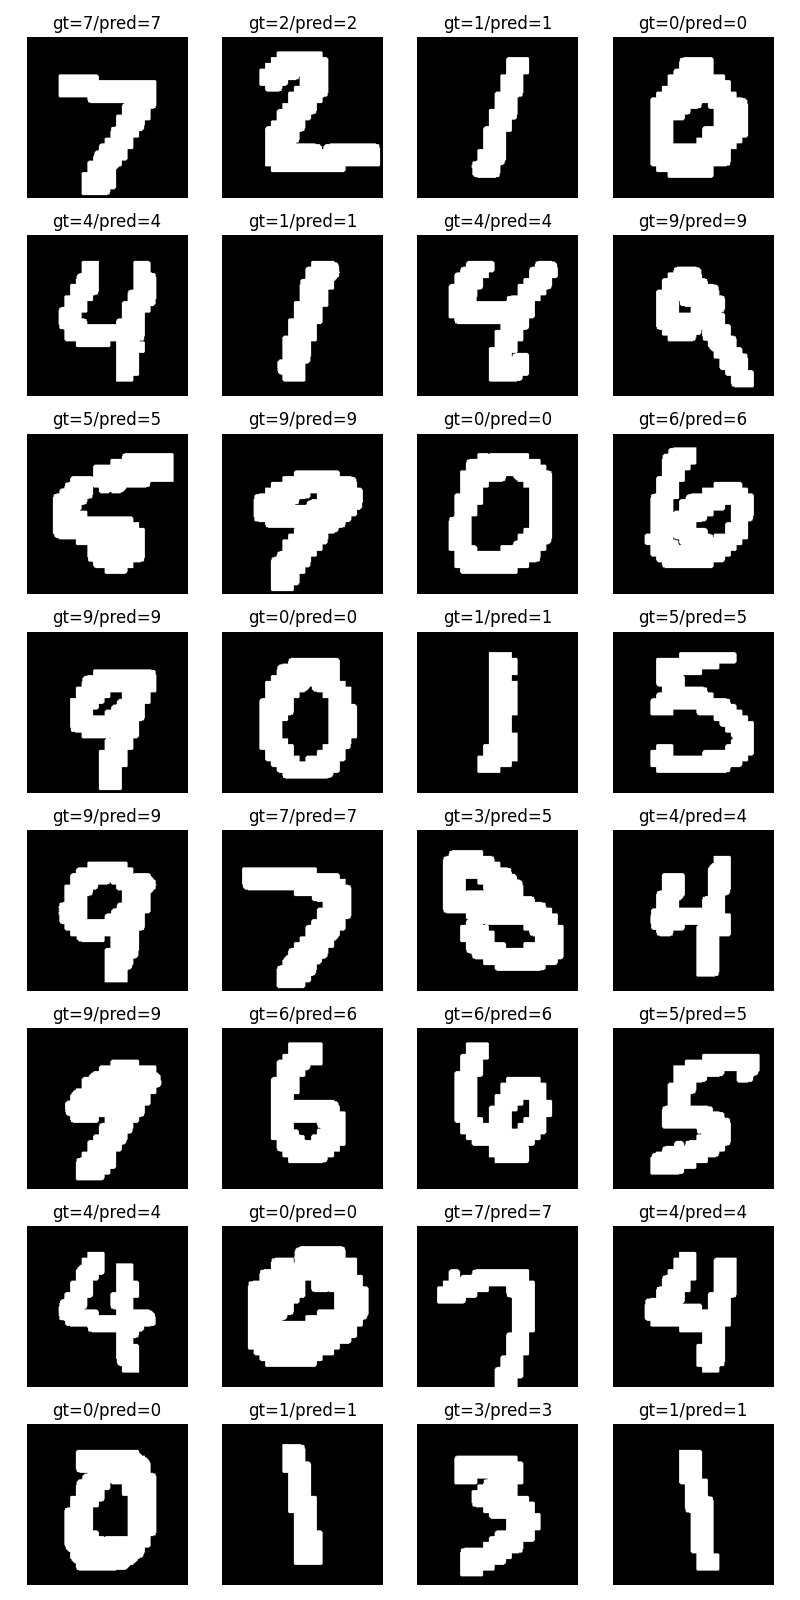

In [129]:
fig, axs = plt.subplots(math.ceil(len(pred_labels) / 4),4, figsize=(8, 16))
axs = axs.ravel()
for ax, img, pred_label, gt_label in zip(axs, imgs.permute(0, 2, 3, 1).numpy(), pred_labels, gt_labels):
    ax.imshow(img)
    ax.set_title(f"gt={gt_label}/pred={pred_label}")
    ax.set_axis_off()

fig.tight_layout()
    
